# Parameter Correlations & Model Development

In [199]:
# Import third party libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import linear_model as lm
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from scipy.stats import circmean

The following notebook will explore correlations between the weather, air quality, drilling and production data. The analysis will include exploration of daily measurements as well as monthly measurements. Following this, a simple model will be fit to try to predict certain air pollutants that show correlation with the weather and UOG data.

## Exploring Parameter Correlations

First the four sets of data must be combined into one data frame.

In [201]:
# Read in cleaned weather, air quality, drilling, and production files
AQ_data = pd.read_csv('FarmingtonCommunityHall_AQ.csv')
weather_data = pd.read_csv('weather_data.csv')
drill_data = pd.read_csv('drill_final.csv')
production_data_monthly = pd.read_csv('production_monthly.csv')
production_data_daily = pd.read_csv('production_daily.csv')


# Combine cleaned weather and air quality files into one dataframe
AQ_weather_hourly = weather_data.merge(right=AQ_data,
                                     how='inner')
# Reset DateTimeIndex
AQ_weather_hourly = AQ_weather_hourly.set_index(pd.DatetimeIndex(AQ_weather_hourly['Datetime']))
AQ_weather_hourly.drop('Datetime', axis=1, inplace=True)

# Resample AQ and weather to daily
# Resample by taking the mean value per day
AQ_weather_daily = AQ_weather_hourly.resample('D').mean()
AQ_weather_daily.head()


,TEMP_MEAN_(C),WDIR_VECT_(DEG),WSPD_SCLR_(M/S),HUMIDITY_(%),NOx,SO2,NO,NO2,TRS,O3
Datetime,,,,,,,,,,
2019-01-01,2.879167,261.875000,7.595833,68.220833,0.820833,0.333333,0.268750,0.543750,0.183333,37.122917
2019-01-02,4.066667,256.179167,8.525000,64.683333,0.739583,0.283333,0.229167,0.510417,0.104167,37.287500
2019-01-03,-6.262500,281.950000,2.079167,72.279167,6.056250,0.297917,0.677083,5.362500,0.110417,28.483333
2019-01-04,-7.912500,187.333333,0.779167,88.525000,6.258333,0.687500,0.377083,5.879167,0.172917,24.160417
2019-01-05,-9.120833,121.070833,1.870833,88.825000,5.381250,1.010417,0.737500,4.652083,0.139583,26.127083


The wind direction is given in degrees. As such, the circular mean must be used to conserve the angularity of the parameter. This is done below.

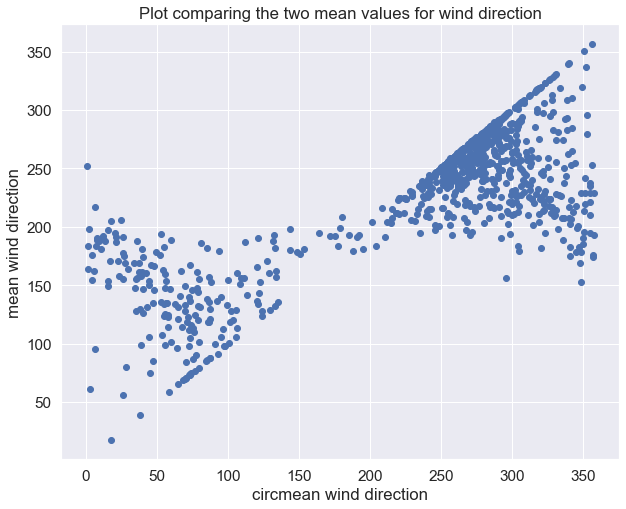

In [204]:
# Use scipy.stats.circmean to compute the circular mean for the samples

# Filter out wind direction to apply a circular mean when resampling to daily
WDIR = AQ_weather_hourly.filter(['WDIR_VECT_(DEG)'], axis=1)

def circular_mean(x):
    return round(np.rad2deg(circmean(np.deg2rad(x['WDIR_VECT_(DEG)'].values))),2)

WDIR_daily = WDIR.resample('D').apply(circular_mean)

# Plot the resample mean wind direction vs the circular mean wind direction
plt.figure(figsize=(10,8))
plt.title('Plot comparing the two mean values for wind direction')
plt.scatter(WDIR_daily, AQ_weather_daily['WDIR_VECT_(DEG)'])
plt.ylabel('mean wind direction')
plt.xlabel('circmean wind direction')
plt.show()

In [208]:
# Add circular mean rather than mean
AQ_weather_daily['WDIR_VECT_(DEG)'] = WDIR_daily
AQ_weather_daily.head()

,TEMP_MEAN_(C),WDIR_VECT_(DEG),WSPD_SCLR_(M/S),HUMIDITY_(%),NOx,SO2,NO,NO2,TRS,O3
Datetime,,,,,,,,,,
2019-01-01,2.879167,261.97,7.595833,68.220833,0.820833,0.333333,0.268750,0.543750,0.183333,37.122917
2019-01-02,4.066667,256.22,8.525000,64.683333,0.739583,0.283333,0.229167,0.510417,0.104167,37.287500
2019-01-03,-6.262500,290.07,2.079167,72.279167,6.056250,0.297917,0.677083,5.362500,0.110417,28.483333
2019-01-04,-7.912500,21.19,0.779167,88.525000,6.258333,0.687500,0.377083,5.879167,0.172917,24.160417
2019-01-05,-9.120833,65.03,1.870833,88.825000,5.381250,1.010417,0.737500,4.652083,0.139583,26.127083


In [209]:
# Combine daily weather, AQ and drilling and production

# Rename date columns to match AQ and weather and set as Datetime Index
drill_data.rename(columns={'Date':'Datetime'}, inplace=True)
drill_data = drill_data.set_index(pd.DatetimeIndex(drill_data['Datetime']))
drill_data.drop('Datetime', axis=1, inplace=True)

# Combine AQ, weather and drilling
AQ_weather_drilling_daily = AQ_weather_daily.merge(right=drill_data,
                                                  how='inner',
                                                  left_index=True,
                                                  right_index=True)

# Rename date columns to match AQ and weather and set as Datetime Index
production_data_daily.rename(columns={'Date':'Datetime'}, inplace=True)
production_data_daily = production_data_daily.set_index(pd.DatetimeIndex(production_data_daily['Datetime']))
production_data_daily.drop('Datetime', axis=1, inplace=True)

# Combine AQ, weather and drilling
AQ_weather_drilling_prod_daily = AQ_weather_drilling_daily.merge(right=production_data_daily,
                                                                 how='inner',
                                                                 left_index=True,
                                                                 right_index=True)

# Re-oder the columns of the dataframe so that drilling and gas production comes before AQ parameters
AQ_weather_drilling_prod_daily = AQ_weather_drilling_prod_daily[['TEMP_MEAN_(C)','WDIR_VECT_(DEG)','WSPD_SCLR_(M/S)','HUMIDITY_(%)','Depth_per_day','gas_prod_vol_m3','SO2','TRS','NOx','NO','NO2','O3']]

# View df
AQ_weather_drilling_prod_daily.head()

,TEMP_MEAN_(C),WDIR_VECT_(DEG),WSPD_SCLR_(M/S),HUMIDITY_(%),Depth_per_day,gas_prod_vol_m3,SO2,TRS,NOx,NO,NO2,O3
Datetime,,,,,,,,,,,,
2019-01-01,2.879167,261.97,7.595833,68.220833,252.000000,168187.648387,0.333333,0.183333,0.820833,0.268750,0.543750,37.122917
2019-01-02,4.066667,256.22,8.525000,64.683333,252.000000,168187.648387,0.283333,0.104167,0.739583,0.229167,0.510417,37.287500
2019-01-03,-6.262500,290.07,2.079167,72.279167,588.502415,168187.648387,0.297917,0.110417,6.056250,0.677083,5.362500,28.483333
2019-01-04,-7.912500,21.19,0.779167,88.525000,807.002415,168187.648387,0.687500,0.172917,6.258333,0.377083,5.879167,24.160417
2019-01-05,-9.120833,65.03,1.870833,88.825000,807.002415,168187.648387,1.010417,0.139583,5.381250,0.737500,4.652083,26.127083


Next, correlations of the daily values will be explored.

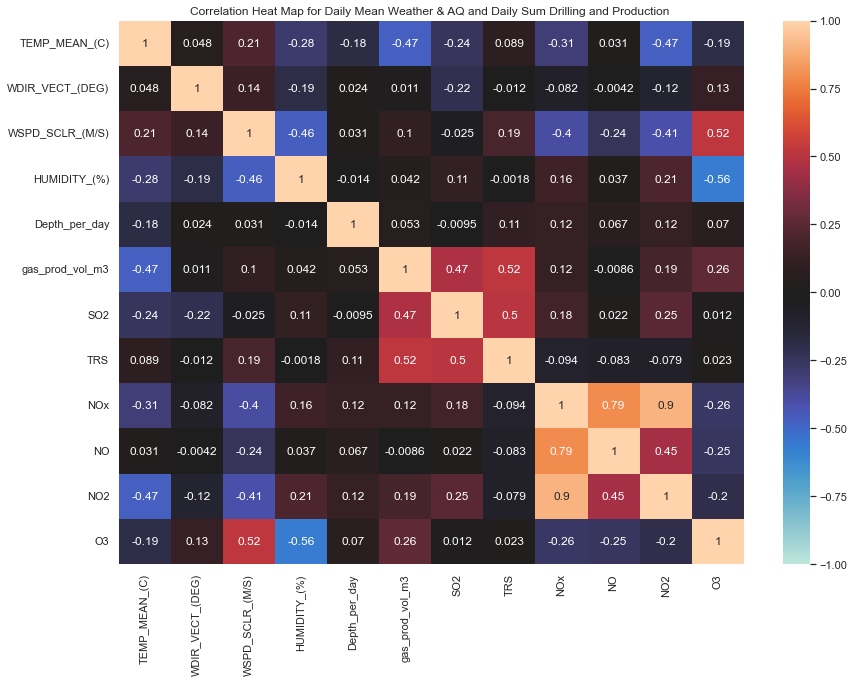

In [213]:
# Plot correlation heat map for all parameters using mean values for weather and AQ and summed values for drilling and production

plt.figure(figsize=(14,10))
sns.set(font_scale=1)
sns.heatmap(AQ_weather_drilling_prod_daily.corr(), vmin=-1, vmax=1, annot=True, cmap='icefire')
plt.title('Correlation Heat Map for Daily Mean Weather & AQ and Daily Sum Drilling and Production ')
plt.show()

From the above figure we see that:
NOx:
 - negatively correlated with temperature and wind speed. NOx is also correlated with NO and NO2
 - shows no correlations with oil and gas data

SO2:
 - negatively correlated with temperature and wind direction and positively correlated with TRS
 - shows a positive correlation with the gas production volumes

NO:
 - slight negative correlation with wind speed and a correlation with other N species

NO2:
 - negatively correlated with temperature and wind speed

TRS:
 - correlated with other sulphur species and with gas production volumes

O3:
 - positive correlation with windpeed, negative correlation with humidity
 - slight correlation with gas production volumes


The daily values can then be resampled using the index into weekly and monthly mean datasets.For example, rather than comparing the monthly mean AQ and weather data to the total depth drilled and total gas produced in a month, the following figures will explore correlations between the mean AQ and weather data and the mean depth drilled and gas produced.

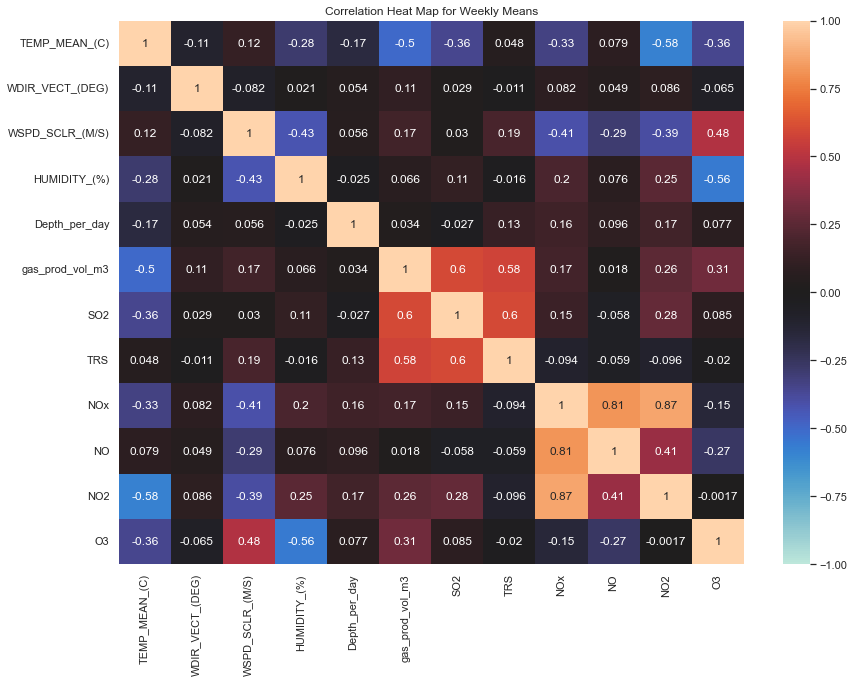

In [214]:
# Re-sample weekly mean for all paramters and plot correlation
week_mean = AQ_weather_drilling_prod_daily.resample('w').mean()

# Make sure to use circ mean when re-sampling wind direction

# Filter out wind direction to apply a circular mean when resampling to daily
WDIR = AQ_weather_hourly.filter(['WDIR_VECT_(DEG)'], axis=1)

def circular_mean(x):
    return round(np.rad2deg(circmean(np.deg2rad(x['WDIR_VECT_(DEG)'].values))),2)

WDIR_weekly = WDIR.resample('w').apply(circular_mean)
week_mean['WDIR_VECT_(DEG)'] = WDIR_weekly

plt.figure(figsize=(14,10))
sns.set(font_scale=1)
sns.heatmap(week_mean.corr(), vmin=-1, vmax=1, annot=True, cmap='icefire')
plt.title('Correlation Heat Map for Weekly Means')
plt.show()

From the above figure we see that:
SO2:
- stronger negative correlation with wind compared to daily mean
- stronger positive correlation with gas production compared to daily mean
- no correlation with other variables

TRS:
- Positive correlation with wind speed, depth drilled and gas produced (all stronger than daily mean correlations)

NOx:
- Negative correlation with temperature and wind speed
- Some positive correlation with humidity, depth per day and gas produced

NO:
- Negative correlation with wind speed

NO2:
- Negative correlation with temperature and wind speed
- Positive correlation with humidity, depth per day and gas produced

O3:
- Negative correlation with temperature and humidity
- Positive correlation with gas produced


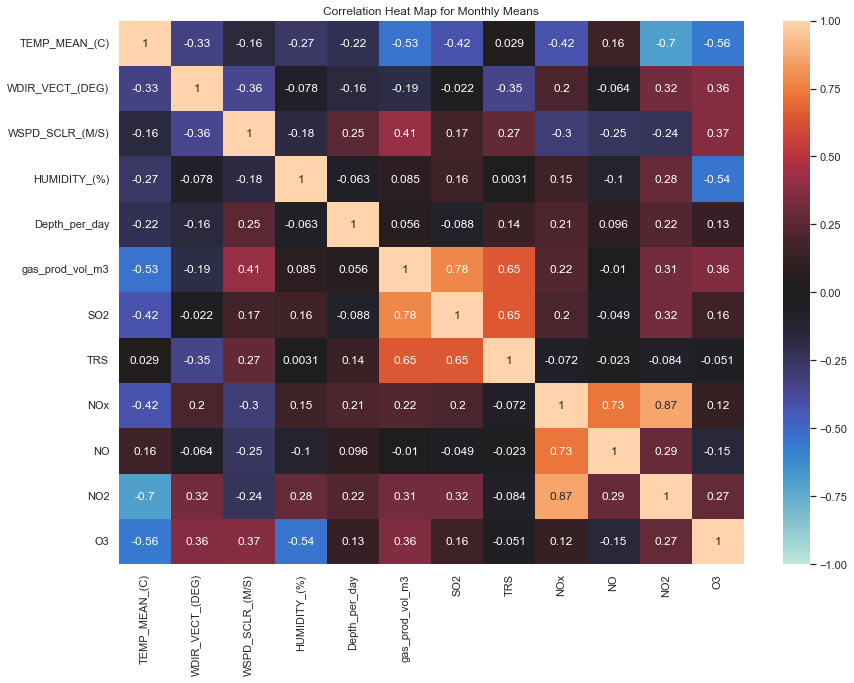

In [212]:
# Re-sample monthly mean for all parameters and plot correlation
month_mean = AQ_weather_drilling_prod_daily.resample('m').mean()

# Make sure to use circ mean when re-sampling wind direction

# Filter out wind direction to apply a circular mean when resampling to daily
WDIR = AQ_weather_hourly.filter(['WDIR_VECT_(DEG)'], axis=1)

def circular_mean(x):
    return round(np.rad2deg(circmean(np.deg2rad(x['WDIR_VECT_(DEG)'].values))),2)

WDIR_monthly = WDIR.resample('m').apply(circular_mean)
month_mean['WDIR_VECT_(DEG)'] = WDIR_monthly

plt.figure(figsize=(14,10))
sns.set(font_scale=1)
sns.heatmap(month_mean.corr(), vmin=-1, vmax=1, annot=True, cmap='icefire')
plt.title('Correlation Heat Map for Monthly Means')
plt.show()

From the above figure we see that:
SO2:
- stronger negative correlation with wind compared to daily and weekly
- stronger positive correlation with gas production compared to daily and weekly mean
- some correlation with wind speed and humidity

TRS:
- Positive correlation with wind speed, depth drilled and gas produced (all stronger than daily and weekly mean correlations)
- Some negative correlation with month mean wind direction

NOx:
- Negative correlation with temperature and wind speed
- Some positive correlation with wind direction, humidity, depth per day and gas produced

NO:
- Negative correlation with wind speed
- some positive correlation with temperature

NO2:
- Negative correlation with temperature and wind speed
- Positive correlation with wind direction, humidity, depth per day and gas produced

O3:
- Negative correlation with temperature and humidity
- Positive correlation with wind direction, wind speed, depth per day and gas produced

 ## MODEL DEVELOPMENT:

The following section will build models to predict the concentrations of SO2, TRS, NO2 and O3.
The model will use the monthly mean of all parameters as this heat map showed the strongest correlation amongst parameters. The dependant variables for each model are selected based on the above correlation heat map for monthly means.

Wind direction as excluded as a possible parameter, as the wind direction is expected to change on an hourly basis, and aggregating wind direction into a monthly value was decided to have low meaning. As shown in the above heatmap, wind direction and mean monthly depth drilled appear to have a slight "correlated", however there is no real-life causation between drilling and wind direction.

### Definition of Models

**Y1: SO2**
X1: Temperature, X2: Wind speed, X3: Humidity, X4: Gas produced

**Y2: TRS**
X1: Wind speed, X2: Depth drilled, X3: Gas produced

**Y3: NO2**
X1: Temperature, X3: Wind speed, X4: Humidity, X5: Depth drilled, X6: Gas produced

**Y4: O3**
X1: Temperature, X3: Wind speed, X4: Humidity, X5: Depth drilled, X6: Gas produced

### Data Splitting, Loss Functions & Cross-Validation

**Data Splitting**
The dataset will be split into a training and a testing dataset. The test dataset will include approximately 1/3 of the dataset to ensure that both the testing and the training sets are representative of the smaller-sized dataset.

**Feature Selection**
The correlation heat maps will be used to select the dependant variables. The features will not be sclaed as the data was aggregated to monthly, and therefore the time to converge is not a concern as it is not a very large dataset to model.

**Loss Functions**
The sklearn LinearRegression fits a linear model that minimizes the Root Mean Squared Error (RMSE) loss function. This loss function cannot be changed. This loss function has the model learn the outlier data but applies high penalties to incorrect predictions on outlier data points.

**Cross Validation**
The train-validation-test split will not be used. The model is working with a smaller dataset as it is aggregated monthly. Therefore, the data will only be split into a training and a testing set. By introducing a validation set, the smaller size of the training, validation, and testing set will be less representative of the sample data. A Grid Search Cross-Validation will be used. This grid will explore different parameters for the Linear Regression, including the intercept and is the regressors X will be normalized before regression. A 5-fold split will be used in this grid search to cross validate.

**Evaluation & Testing**
The model will be evaluated using the R^2^ score. The R^2^ measures the proportion of variance in the dependant variable that is predictable from the independent variables and is commonly used for linear regression. A higher R^2^ value indicates a better fit. Residual plots will also be used to ensure no transformations are required for the data and a linear model was the best choice (versus a polynomial).

**Other Possible Models for Future Consideration**
Sklearn offers another linear regression: the Huber Regressor that is a linear regression more robust to outliers.

### Visualization of Data
Before fitting any models, the data was visualized using various panelled scatter plots.

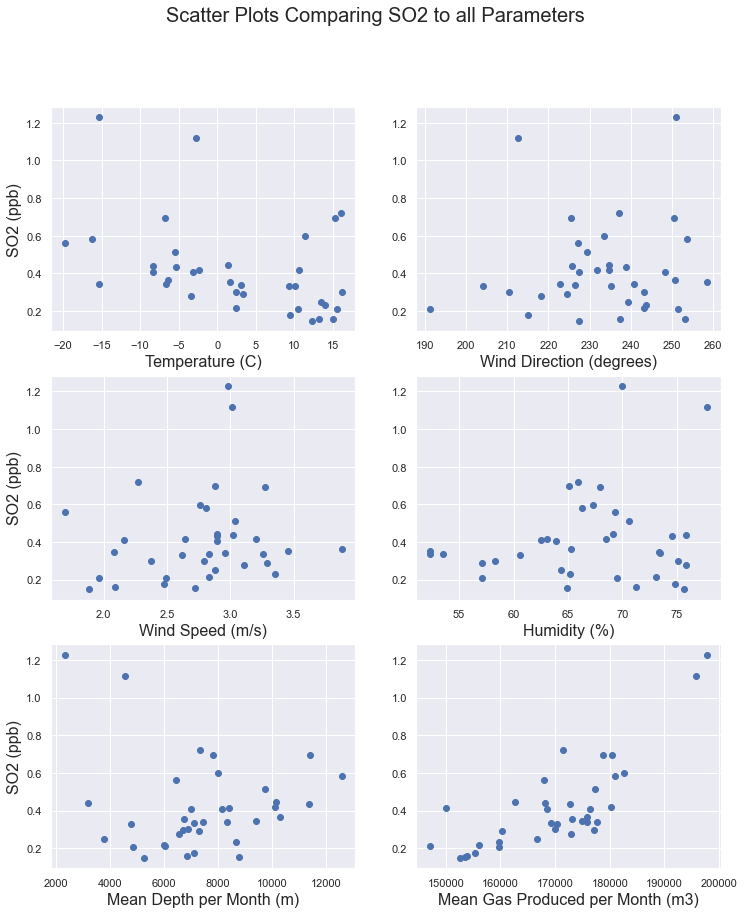

In [100]:
# Plot scatter plot of monthly data for SO2 vs weather and UOG parameters

y = month_mean['SO2']

x1 = month_mean['TEMP_MEAN_(C)']
x2 = month_mean['WDIR_VECT_(DEG)']
x3 = month_mean['WSPD_SCLR_(M/S)']
x4 = month_mean['HUMIDITY_(%)']
x5 = month_mean['Depth_per_day']
x6 = month_mean['gas_prod_vol_m3']

#sns.set(font_scale=1)

fig, axs = plt.subplots(3,2, figsize=(12,14))
fig.suptitle('Scatter Plots Comparing SO2 to all Parameters', fontsize=20)

axs[0,0].scatter(x1,y)
axs[0,0].set_xlabel('Temperature (C)', fontsize=16)
axs[0,0].set_ylabel('SO2 (ppb)', fontsize=16)
axs[0,1].scatter(x2,y)
axs[0,1].set_xlabel('Wind Direction (degrees)', fontsize=16)
#axs[0,1].set_ylabel('SO2 (ppb)', fontsize=16)

axs[1,0].scatter(x3,y)
axs[1,0].set_xlabel('Wind Speed (m/s)', fontsize=16)
axs[1,0].set_ylabel('SO2 (ppb)', fontsize=16)
axs[1,1].scatter(x4,y)
axs[1,1].set_xlabel('Humidity (%)', fontsize=16)
#axs[1,1].set_ylabel('SO2 (ppb)', fontsize=16)

axs[2,0].scatter(x5,y)
axs[2,0].set_xlabel('Mean Depth per Month (m)', fontsize=16)
axs[2,0].set_ylabel('SO2 (ppb)', fontsize=16)
axs[2,1].scatter(x6,y)
axs[2,1].set_xlabel('Mean Gas Produced per Month (m3)', fontsize=16)


plt.show()

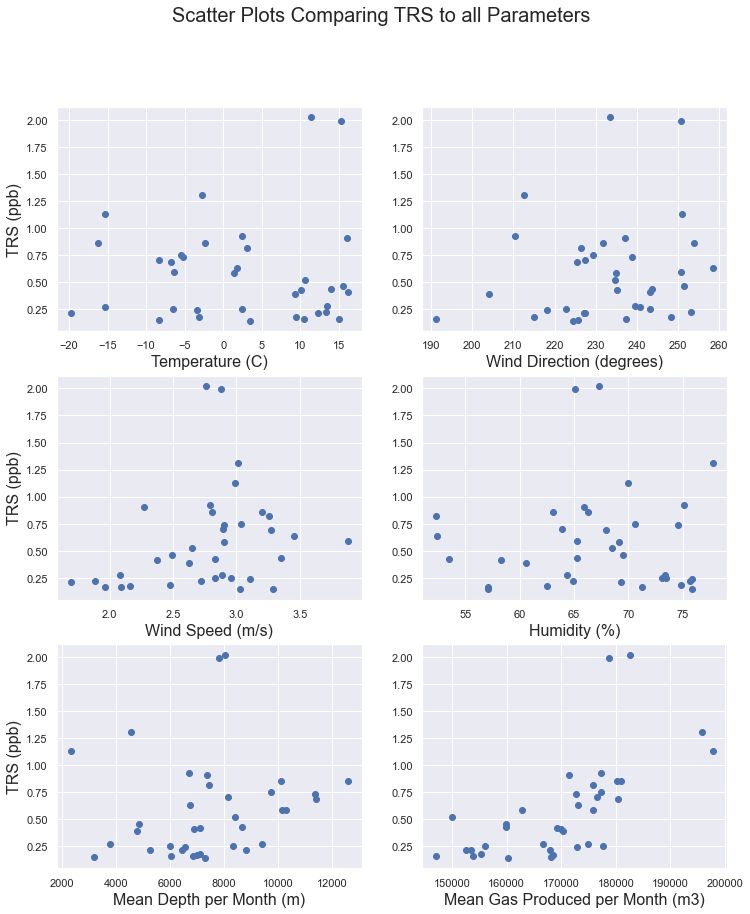

In [101]:
# Plot scatter plot of monthly data for TRS vs weather and UOG parameters

y = month_mean['TRS']

x1 = month_mean['TEMP_MEAN_(C)']
x2 = month_mean['WDIR_VECT_(DEG)']
x3 = month_mean['WSPD_SCLR_(M/S)']
x4 = month_mean['HUMIDITY_(%)']
x5 = month_mean['Depth_per_day']
x6 = month_mean['gas_prod_vol_m3']

#sns.set(font_scale=1)

fig, axs = plt.subplots(3,2, figsize=(12,14))
fig.suptitle('Scatter Plots Comparing TRS to all Parameters', fontsize=20)

axs[0,0].scatter(x1,y)
axs[0,0].set_xlabel('Temperature (C)', fontsize=16)
axs[0,0].set_ylabel('TRS (ppb)', fontsize=16)
axs[0,1].scatter(x2,y)
axs[0,1].set_xlabel('Wind Direction (degrees)', fontsize=16)

axs[1,0].scatter(x3,y)
axs[1,0].set_xlabel('Wind Speed (m/s)', fontsize=16)
axs[1,0].set_ylabel('TRS (ppb)', fontsize=16)
axs[1,1].scatter(x4,y)
axs[1,1].set_xlabel('Humidity (%)', fontsize=16)

axs[2,0].scatter(x5,y)
axs[2,0].set_xlabel('Mean Depth per Month (m)', fontsize=16)
axs[2,0].set_ylabel('TRS (ppb)', fontsize=16)
axs[2,1].scatter(x6,y)
axs[2,1].set_xlabel('Mean Gas Produced per Month (m3)', fontsize=16)


plt.show()

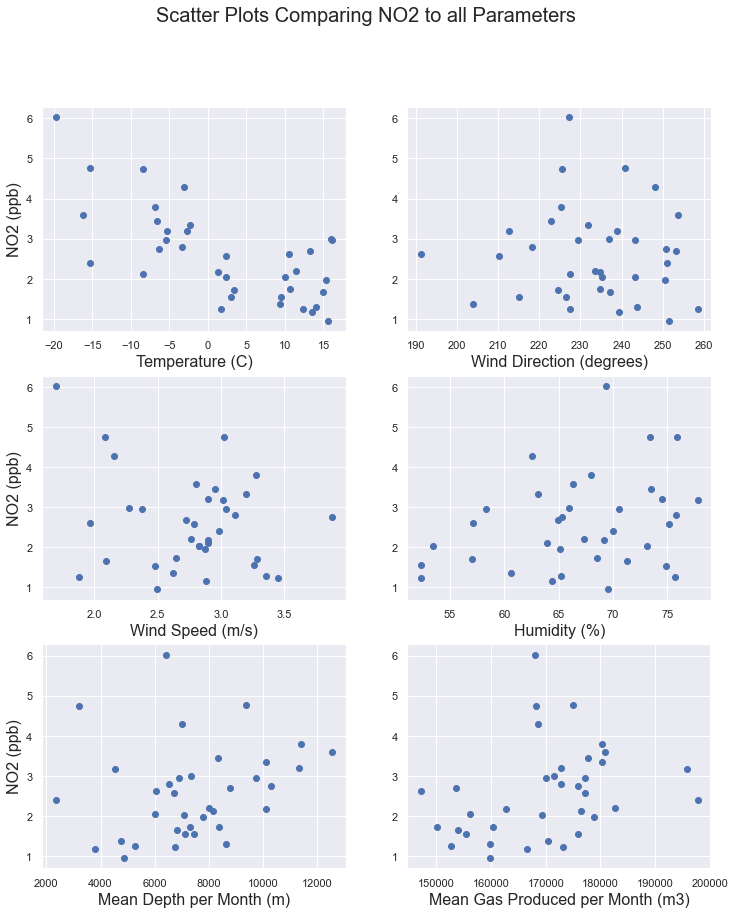

In [102]:
# Plot scatter plot of monthly data for NO2 vs weather and UOG parameters

y = month_mean['NO2']

x1 = month_mean['TEMP_MEAN_(C)']
x2 = month_mean['WDIR_VECT_(DEG)']
x3 = month_mean['WSPD_SCLR_(M/S)']
x4 = month_mean['HUMIDITY_(%)']
x5 = month_mean['Depth_per_day']
x6 = month_mean['gas_prod_vol_m3']

#sns.set(font_scale=1)

fig, axs = plt.subplots(3,2, figsize=(12,14))
fig.suptitle('Scatter Plots Comparing NO2 to all Parameters', fontsize=20)

axs[0,0].scatter(x1,y)
axs[0,0].set_xlabel('Temperature (C)', fontsize=16)
axs[0,0].set_ylabel('NO2 (ppb)', fontsize=16)
axs[0,1].scatter(x2,y)
axs[0,1].set_xlabel('Wind Direction (degrees)', fontsize=16)

axs[1,0].scatter(x3,y)
axs[1,0].set_xlabel('Wind Speed (m/s)', fontsize=16)
axs[1,0].set_ylabel('NO2 (ppb)', fontsize=16)
axs[1,1].scatter(x4,y)
axs[1,1].set_xlabel('Humidity (%)', fontsize=16)

axs[2,0].scatter(x5,y)
axs[2,0].set_xlabel('Mean Depth per Month (m)', fontsize=16)
axs[2,0].set_ylabel('NO2 (ppb)', fontsize=16)
axs[2,1].scatter(x6,y)
axs[2,1].set_xlabel('Mean Gas Produced per Month (m3)', fontsize=16)

plt.show()

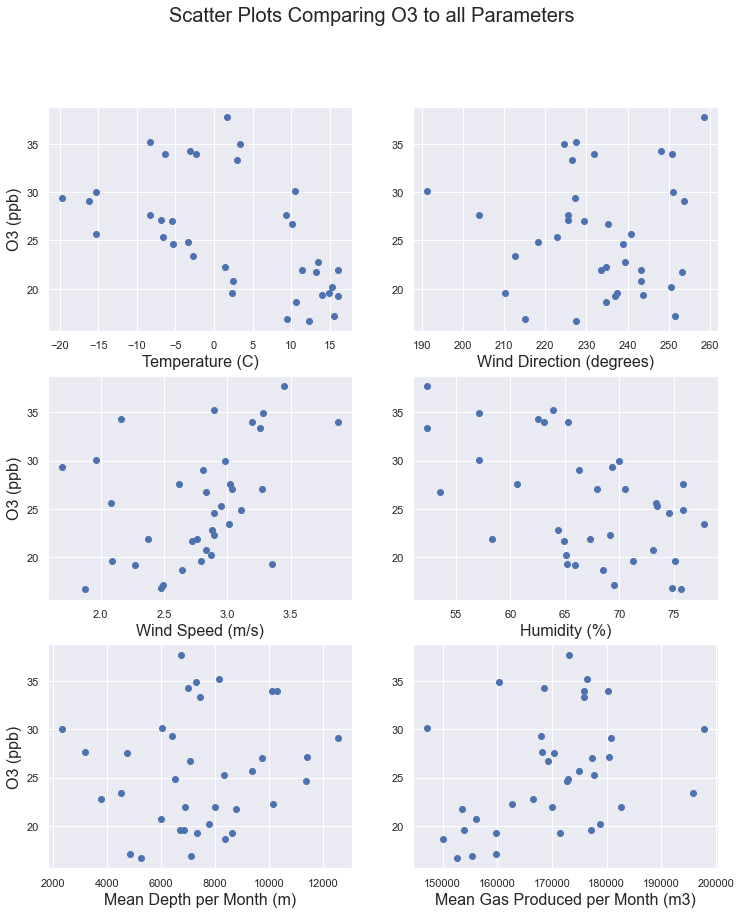

In [103]:
# Plot scatter plot of monthly data for O3 vs weather and UOG parameters

y = month_mean['O3']

x1 = month_mean['TEMP_MEAN_(C)']
x2 = month_mean['WDIR_VECT_(DEG)']
x3 = month_mean['WSPD_SCLR_(M/S)']
x4 = month_mean['HUMIDITY_(%)']
x5 = month_mean['Depth_per_day']
x6 = month_mean['gas_prod_vol_m3']

#sns.set(font_scale=1)

fig, axs = plt.subplots(3,2, figsize=(12,14))
fig.suptitle('Scatter Plots Comparing O3 to all Parameters', fontsize=20)

axs[0,0].scatter(x1,y)
axs[0,0].set_xlabel('Temperature (C)', fontsize=16)
axs[0,0].set_ylabel('O3 (ppb)', fontsize=16)
axs[0,1].scatter(x2,y)
axs[0,1].set_xlabel('Wind Direction (degrees)', fontsize=16)
#axs[0,1].set_ylabel('SO2 (ppb)', fontsize=16)

axs[1,0].scatter(x3,y)
axs[1,0].set_xlabel('Wind Speed (m/s)', fontsize=16)
axs[1,0].set_ylabel('O3 (ppb)', fontsize=16)
axs[1,1].scatter(x4,y)
axs[1,1].set_xlabel('Humidity (%)', fontsize=16)
#axs[1,1].set_ylabel('SO2 (ppb)', fontsize=16)

axs[2,0].scatter(x5,y)
axs[2,0].set_xlabel('Mean Depth per Month (m)', fontsize=16)
axs[2,0].set_ylabel('O3 (ppb)', fontsize=16)
axs[2,1].scatter(x6,y)
axs[2,1].set_xlabel('Mean Gas Produced per Month (m3)', fontsize=16)


plt.show()

#### MODEL 1: SO2

In [104]:
# Split df into x and y
X =  month_mean.filter(['TEMP_MEAN_(C)', 'WSPD_SCLR_(M/S)', 'HUMIDITY_(%)', 'gas_prod_vol_m3'], axis=1)
y = month_mean.filter(['SO2'], axis=1)

# Split the data into a training and a testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

# Print test and trainning sizes
print('Train {}%'.format(X_train.shape[0] / month_mean.shape[0] * 100))
print('Test {}%'.format(X_test.shape[0] / month_mean.shape[0] * 100))


Train 66.66666666666666%
Test 33.33333333333333%


In [105]:
# Create a LinearRegression object and name it linear_model
linear_model = lm.LinearRegression(fit_intercept=True)

# Define parameters to explore
parameters = [{'fit_intercept':[True, False],
               'normalize':[True, False]}]

# Hyper-Parameter Tuning and Cross Validation
grid_search = GridSearchCV(estimator=linear_model,
                           param_grid=parameters,
                           scoring = 'r2',
                           cv = 5,
                           verbose =0,
                           return_train_score=True)
# Fit model to training data
grid_search.fit(X_train, y_train)

# Predict training data y using model
y_fitted = grid_search.predict(X_train)

# Print the r-squared value
print(r2_score(y_train, y_fitted))

0.7226786786987176


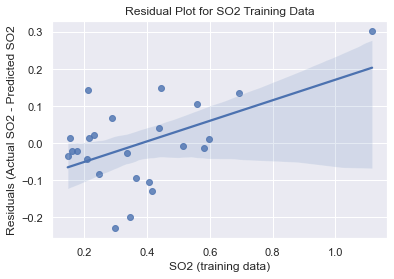

In [106]:
# Plot the residuals
residuals = y_train - y_fitted
ax = sns.regplot(x=y_train, y=residuals['SO2'])
ax.set_xlabel('SO2 (training data)')
ax.set_ylabel('Residuals (Actual SO2 - Predicted SO2')
plt.title('Residual Plot for SO2 Training Data')
plt.show()

In [107]:
# Now predict the test values and calculate the r-squared score
y_fitted = grid_search.predict(X_test)
print(r2_score(y_test, y_fitted))

0.4421264405843882


#### MODEL 2: TRS

In [108]:
# Split df into x and y
X =  month_mean.filter(['WSPD_SCLR_(M/S)', 'WDIR_VECT_(DEG)', 'Depth_per_day', 'gas_prod_vol_m3'], axis=1)
y = month_mean.filter(['TRS'], axis=1)

# Split the data into a training and a testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=10)

# Print test and trainning sizes
print('Train {}%'.format(X_train.shape[0] / month_mean.shape[0] * 100))
print('Test {}%'.format(X_test.shape[0] / month_mean.shape[0] * 100))

Train 66.66666666666666%
Test 33.33333333333333%


In [109]:
# Create a LinearRegression object and name it linear_model
linear_model = lm.LinearRegression(fit_intercept=True)

# Define parameters to explore
parameters = [{'fit_intercept':[True, False],
               'normalize':[True, False]}]

# Hyper-Parameter Tuning and Cross Validation
grid_search = GridSearchCV(estimator=linear_model,
                           param_grid=parameters,
                           scoring = 'r2',
                           cv = 5,
                           verbose =0,
                           return_train_score=True)
# Fit model to training data
grid_search.fit(X_train, y_train)

# Predict training data y using model
y_fitted = grid_search.predict(X_train)

# Print the r-squared value
print(r2_score(y_train, y_fitted))

0.6450973178658227


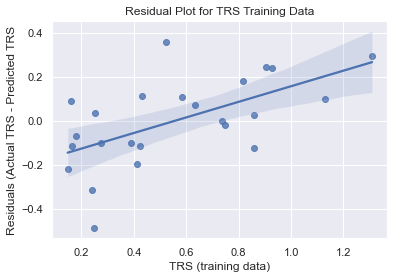

In [110]:
# Plot the residuals
residuals = y_train - y_fitted
ax = sns.regplot(x=y_train, y=residuals['TRS'])
ax.set_xlabel('TRS (training data)')
ax.set_ylabel('Residuals (Actual TRS - Predicted TRS')
plt.title('Residual Plot for TRS Training Data')
plt.show()

In [111]:
# Now predict the test values and calculate the r-squared score
y_fitted = grid_search.predict(X_test)
print(r2_score(y_test, y_fitted))

0.28315363368084656


#### MODEL 3: NO2

In [112]:
# Split df into x and y
X =  month_mean.filter(['TEMP_MEAN_(C)', 'WSPD_SCLR_(M/S)', 'HUMIDITY_(%)', 'Depth_per_day','gas_prod_vol_m3'], axis=1)
y = month_mean.filter(['NO2'], axis=1)

# Split the data into a training and a testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=10)

# Print test and trainning sizes
print('Train {}%'.format(X_train.shape[0] / month_mean.shape[0] * 100))
print('Test {}%'.format(X_test.shape[0] / month_mean.shape[0] * 100))

Train 66.66666666666666%
Test 33.33333333333333%


In [113]:
# Create a LinearRegression object and name it linear_model
linear_model = lm.LinearRegression(fit_intercept=True)

# Define parameters to explore
parameters = [{'fit_intercept':[True, False],
               'normalize':[True, False]}]

# Hyper-Parameter Tuning and Cross Validation
grid_search = GridSearchCV(estimator=linear_model,
                           param_grid=parameters,
                           scoring = 'r2',
                           cv = 5,
                           verbose =0,
                           return_train_score=True)
# Fit model to training data
grid_search.fit(X_train, y_train)

# Predict training data y using model
y_fitted = grid_search.predict(X_train)

# Print the r-squared value
print(r2_score(y_train, y_fitted))

0.49528414264172893


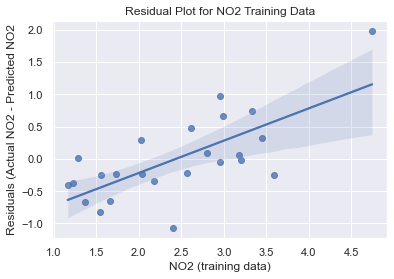

In [114]:
# Plot the residuals
residuals = y_train - y_fitted
ax = sns.regplot(x=y_train, y=residuals['NO2'])
ax.set_xlabel('NO2 (training data)')
ax.set_ylabel('Residuals (Actual NO2 - Predicted NO2')
plt.title('Residual Plot for NO2 Training Data')
plt.show()

In [115]:
# Now predict the test values and calculate the r-squared score
y_fitted = grid_search.predict(X_test)
print(r2_score(y_test, y_fitted))

0.6439081443179628


#### MODEL 4: O3

In [116]:
# Split df into x and y
X =  month_mean.filter(['TEMP_MEAN_(C)', 'WSPD_SCLR_(M/S)', 'HUMIDITY_(%)','gas_prod_vol_m3'], axis=1)
y = month_mean.filter(['O3'], axis=1)

# Split the data into a training and a testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

# Print test and trainning sizes
print('Train {}%'.format(X_train.shape[0] / month_mean.shape[0] * 100))
print('Test {}%'.format(X_test.shape[0] / month_mean.shape[0] * 100))

Train 66.66666666666666%
Test 33.33333333333333%


In [117]:
# Create a LinearRegression object and name it linear_model
linear_model = lm.LinearRegression(fit_intercept=True)

# Define parameters to explore
parameters = [{'fit_intercept':[True, False],
               'normalize':[True, False]}]

# Hyper-Parameter Tuning and Cross Validation
grid_search = GridSearchCV(estimator=linear_model,
                           param_grid=parameters,
                           scoring = 'r2',
                           cv = 5,
                           verbose =0,
                           return_train_score=True)
# Fit model to training data
grid_search.fit(X_train, y_train)

# Predict training data y using model
y_fitted = grid_search.predict(X_train)

# Print the r-squared value
print(r2_score(y_train, y_fitted))

0.5290019256755933


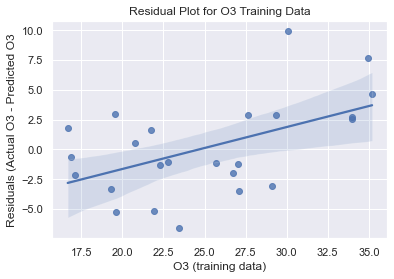

In [118]:
# Plot the residuals
residuals = y_train - y_fitted
ax = sns.regplot(x=y_train, y=residuals['O3'])
ax.set_xlabel('O3 (training data)')
ax.set_ylabel('Residuals (Actual O3 - Predicted O3')
plt.title('Residual Plot for O3 Training Data')
plt.show()

In [119]:
# Now predict the test values and calculate the r-squared score
y_fitted = grid_search.predict(X_test)
print(r2_score(y_test, y_fitted))

0.57458014055905


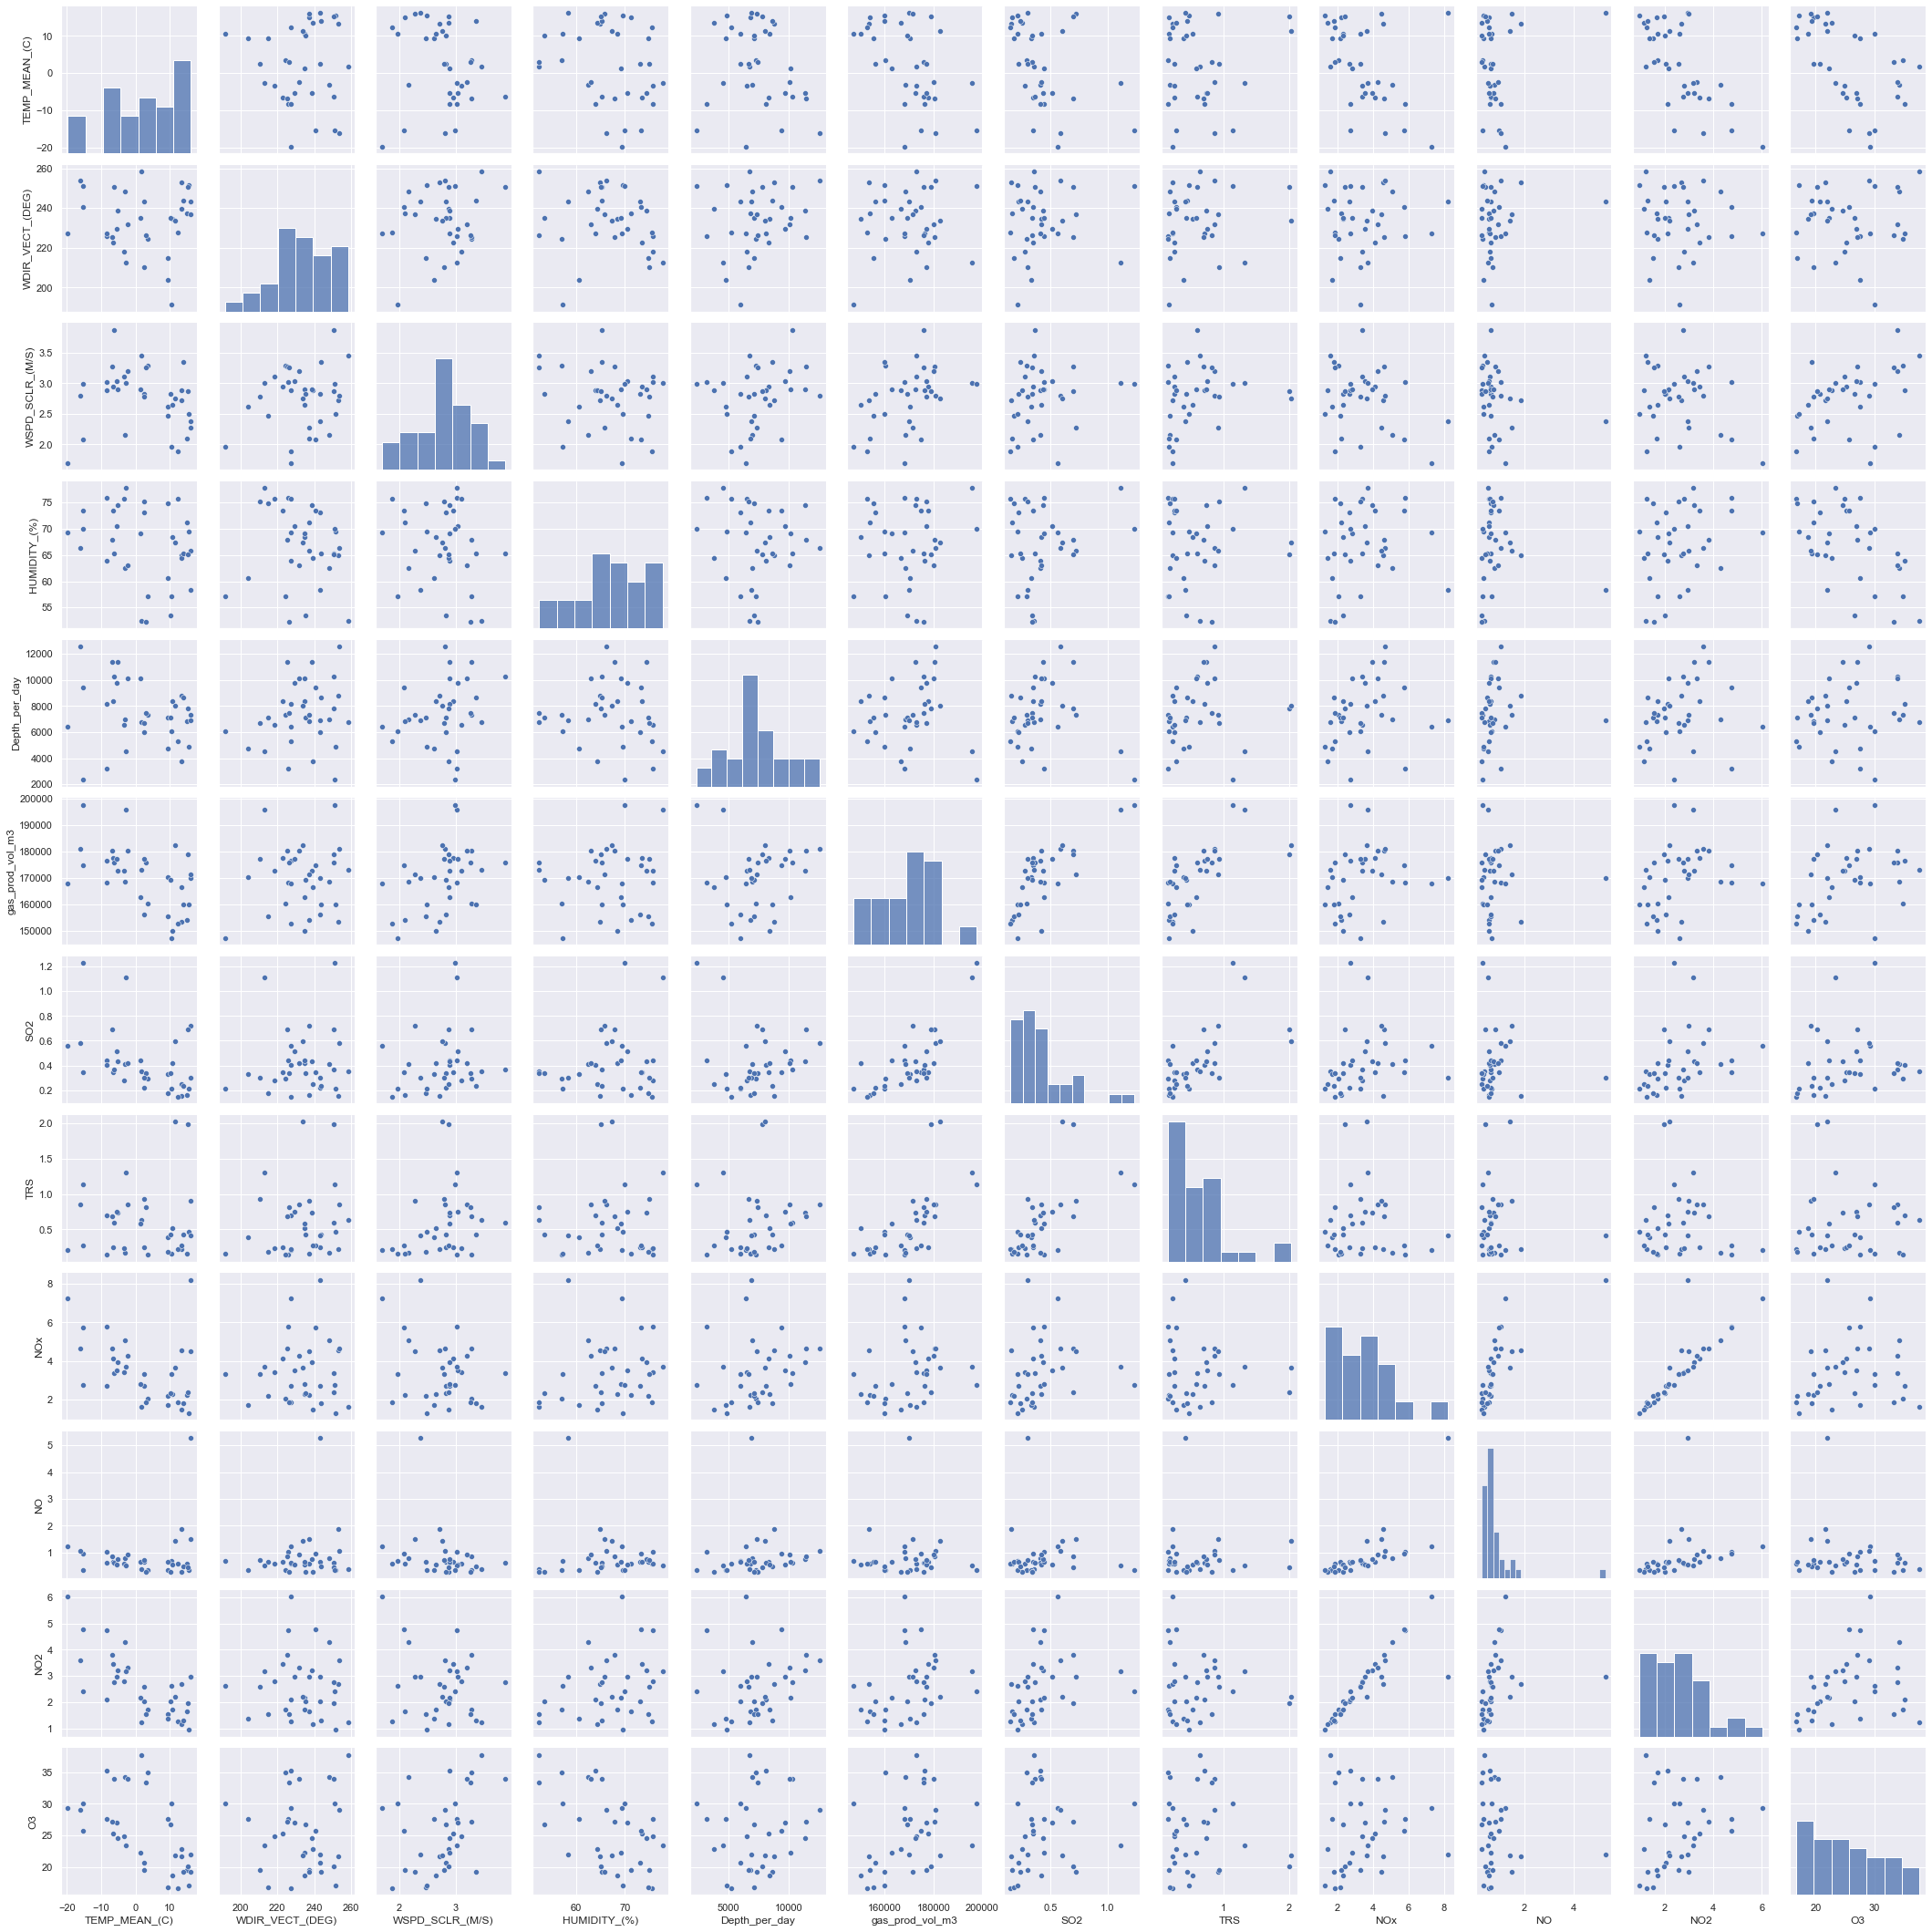

In [120]:
sns.pairplot(month_mean)

## Extra Figures for Presentation Purposes

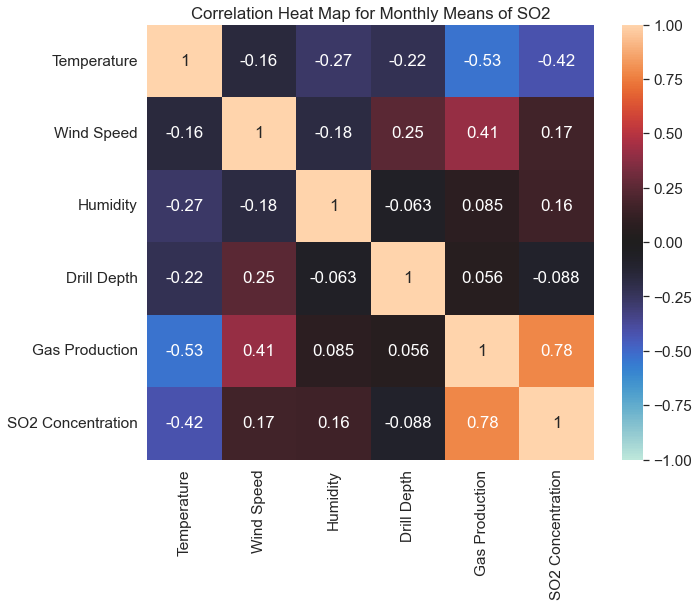

In [121]:
# Generate heatmap for just SO2
SO2 = month_mean.filter(['TEMP_MEAN_(C)','WSPD_SCLR_(M/S)','HUMIDITY_(%)','Depth_per_day','gas_prod_vol_m3','SO2'])
SO2.rename({'TEMP_MEAN_(C)':'Temperature','WSPD_SCLR_(M/S)':'Wind Speed','HUMIDITY_(%)':'Humidity','Depth_per_day':'Drill Depth','gas_prod_vol_m3':'Gas Production','SO2':'SO2 Concentration'}, axis=1, inplace=True)

plt.figure(figsize=(10,8))
sns.set(font_scale=1.4)
sns.heatmap(SO2.corr(), vmin=-1, vmax=1, annot=True, cmap='icefire')
plt.title('Correlation Heat Map for Monthly Means of SO2')
plt.show()

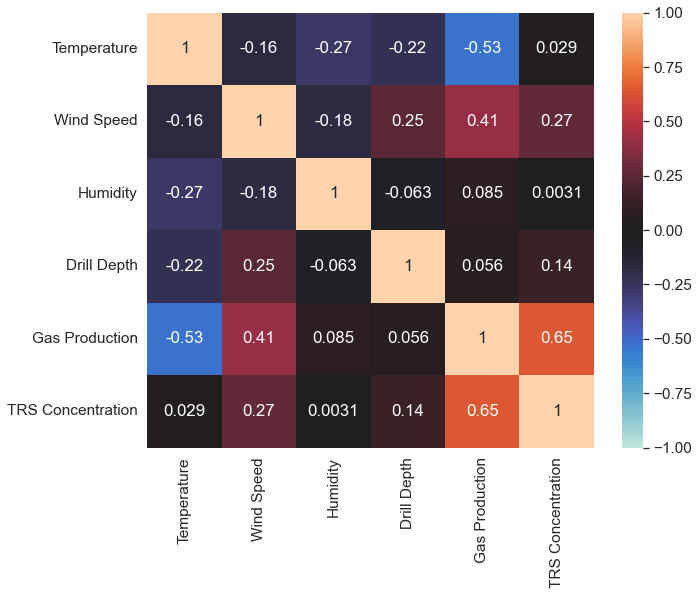

In [122]:
# Generate heatmap for just TRS
TRS = month_mean.filter(['TEMP_MEAN_(C)','WSPD_SCLR_(M/S)','HUMIDITY_(%)','Depth_per_day','gas_prod_vol_m3','TRS'])
TRS.rename({'TEMP_MEAN_(C)':'Temperature','WSPD_SCLR_(M/S)':'Wind Speed','HUMIDITY_(%)':'Humidity','Depth_per_day':'Drill Depth','gas_prod_vol_m3':'Gas Production','TRS':'TRS Concentration'}, axis=1, inplace=True)

plt.figure(figsize=(10,8))
sns.set(font_scale=1.4)
sns.heatmap(TRS.corr(), vmin=-1, vmax=1, annot=True, cmap='icefire')
#plt.title('Correlation Heat Map for Monthly Means of TRS')
plt.show()

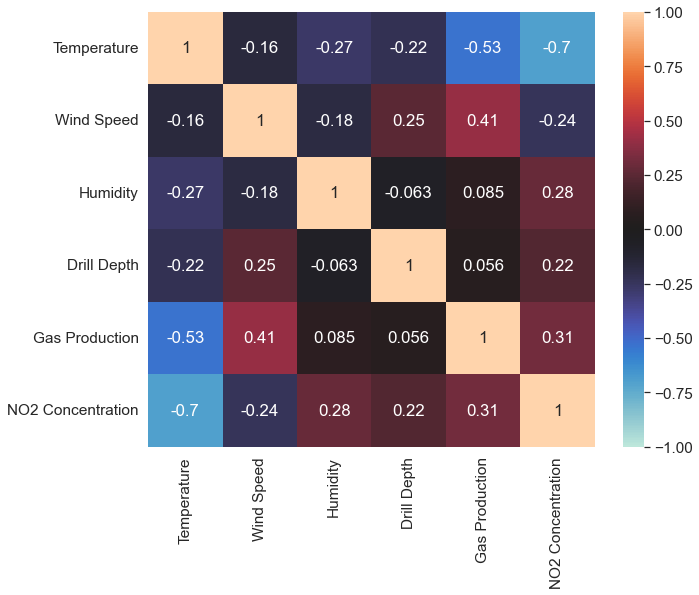

In [123]:
# Generate heatmap for just NO2
NO2 = month_mean.filter(['TEMP_MEAN_(C)','WSPD_SCLR_(M/S)','HUMIDITY_(%)','Depth_per_day','gas_prod_vol_m3','NO2'])
NO2.rename({'TEMP_MEAN_(C)':'Temperature','WSPD_SCLR_(M/S)':'Wind Speed','HUMIDITY_(%)':'Humidity','Depth_per_day':'Drill Depth','gas_prod_vol_m3':'Gas Production','NO2':'NO2 Concentration'}, axis=1, inplace=True)

plt.figure(figsize=(10,8))
sns.set(font_scale=1.4)
sns.heatmap(NO2.corr(), vmin=-1, vmax=1, annot=True, cmap='icefire')
#plt.title('Correlation Heat Map for Monthly Means of NO2')
plt.show()

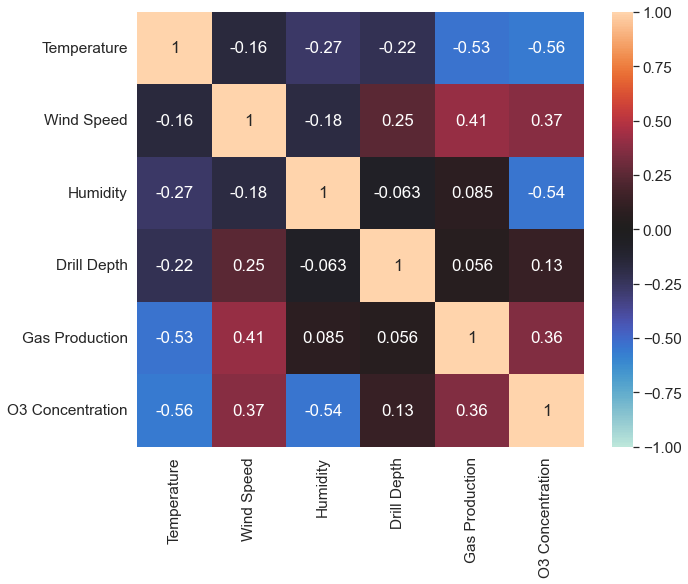

In [124]:
# Generate heatmap for just O3
O3 = month_mean.filter(['TEMP_MEAN_(C)','WSPD_SCLR_(M/S)','HUMIDITY_(%)','Depth_per_day','gas_prod_vol_m3','O3'])
O3.rename({'TEMP_MEAN_(C)':'Temperature','WSPD_SCLR_(M/S)':'Wind Speed','HUMIDITY_(%)':'Humidity','Depth_per_day':'Drill Depth','gas_prod_vol_m3':'Gas Production','O3':'O3 Concentration'}, axis=1, inplace=True)

plt.figure(figsize=(10,8))
sns.set(font_scale=1.4)
sns.heatmap(O3.corr(), vmin=-1, vmax=1, annot=True, cmap='icefire')
#plt.title('Correlation Heat Map for Monthly Means of O3')
plt.show()